In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from state_of_the_artefact.EmbeddingVAE import EmbeddingVAE
from state_of_the_artefact.representation import create_ctable, generate_midi_data
from state_of_the_artefact.utilities import reverse_sequences, interpolate

In [109]:
midi_range = range(25, 36)

def generate(size, timesteps):
    x = []
    seen = set()
    characters = list(midi_range)

    while len(x) < size:
        notes = [random.randint(0, len(characters) - 1) for _ in range(timesteps)]
        tune = [characters[i] for i in notes]

        key = ''.join([f"{note}" for note in tune])
        if key in seen:
            continue
        seen.add(key)

        x.append(tune)
    print(len(seen))
    return x

x = generate(1562 * 32, 10)
x_train, y_train = reverse_sequences(x[:1406 * 32]), np.array(x[:1406 * 32])
x_val, y_val = reverse_sequences(x[1406 * 32:]), np.array(x[1406 * 32:])

print(x_train.shape, y_train[0])

49984
(44992, 10) [32 32 26 33 33 26 26 32 33 26]


In [148]:
BATCH_SIZE =32
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1406 * 32).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((32, 10), (32, 10)), types: (tf.int64, tf.int64)>

In [149]:
cs = EmbeddingVAE(10, 128, 32)
cs.compile(optimizer='adam', loss="mse", metrics=["accuracy"])

In [150]:
hist = cs.fit(x_train, y_train, epochs=50, batch_size=BATCH_SIZE)

Epoch 1/50
1406/1406 [==============================] - 18s 13ms/step - loss: 53.2183 - accuracy: 0.1222 - kl_loss: 0.5663
Epoch 2/50
1406/1406 [==============================] - 19s 13ms/step - loss: 10.5750 - accuracy: 0.1012 - kl_loss: 0.5321
Epoch 3/50
1406/1406 [==============================] - 19s 13ms/step - loss: 10.4912 - accuracy: 0.1079 - kl_loss: 0.3733
Epoch 4/50
1406/1406 [==============================] - 21s 15ms/step - loss: 10.0621 - accuracy: 0.1627 - kl_loss: 0.2755
Epoch 5/50
1406/1406 [==============================] - 19s 14ms/step - loss: 9.3961 - accuracy: 0.2026 - kl_loss: 0.2764
Epoch 6/50
1406/1406 [==============================] - 18s 13ms/step - loss: 8.5756 - accuracy: 0.2302 - kl_loss: 0.3760
Epoch 7/50
1406/1406 [==============================] - 18s 13ms/step - loss: 7.7329 - accuracy: 0.3032 - kl_loss: 0.3892
Epoch 8/50
1406/1406 [==============================] - 18s 13ms/step - loss: 7.0574 - accuracy: 0.3722 - kl_loss: 0.4520
Epoch 9/50
1406/1406

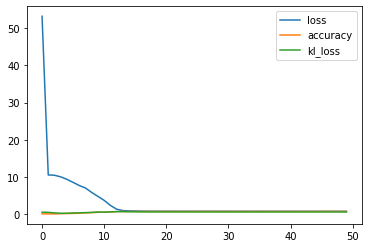

In [151]:
pd.DataFrame(hist.history).plot()

In [152]:
reconstructions = cs.predict(x_train)

print(reconstructions[0])
print(np.array([int(round(note)) for note in reconstructions[0]]))
print(y_train[0])

missclassifieds = 0
for original, reconstruction in zip(y_train, reconstructions):

    if not np.array_equiv(original, np.array([int(round(note)) for note in reconstruction])):
        missclassifieds += 1

print(missclassifieds)

[32.108505 32.118538 25.732656 33.15103  33.50856  25.38925  26.58318
 32.49688  33.27773  26.017803]
[32 32 26 33 34 25 27 32 33 26]
[32 32 26 33 33 26 26 32 33 26]
41603


In [156]:
budget = 200

new_y = np.array(generate(10, 10))
new_x = reverse_sequences(new_y)

missclassifieds = 1
while missclassifieds > 0 and budget > 0:
    missclassifieds = 0
    history = cs.fit(new_x, new_y, epochs=1, batch_size=1)

    reconstructions = cs.predict(new_x)

    for original, reconstruction in zip(new_y, reconstructions):
        if not np.array_equiv(original, np.array([int(round(note)) for note in reconstruction])):
            missclassifieds += 1


    budget -= 1
    print(missclassifieds, budget)


step - loss: 0.9034 - accuracy: 0.5000 - kl_loss: 0.6046
10 180
10/10 [==============================] - 0s 7ms/step - loss: 0.8464 - accuracy: 0.5000 - kl_loss: 0.5921
10 179
10/10 [==============================] - 0s 5ms/step - loss: 0.8172 - accuracy: 0.8000 - kl_loss: 0.5858
10 178
10/10 [==============================] - 0s 7ms/step - loss: 0.8221 - accuracy: 0.5000 - kl_loss: 0.5772
10 177
10/10 [==============================] - 0s 6ms/step - loss: 0.8211 - accuracy: 0.6000 - kl_loss: 0.5674
10 176
10/10 [==============================] - 0s 5ms/step - loss: 0.8760 - accuracy: 0.4000 - kl_loss: 0.5505
10 175
10/10 [==============================] - 0s 5ms/step - loss: 0.8875 - accuracy: 0.8000 - kl_loss: 0.5495
9 174
10/10 [==============================] - 0s 6ms/step - loss: 0.8395 - accuracy: 0.7000 - kl_loss: 0.5504
9 173
10/10 [==============================] - 0s 5ms/step - loss: 0.8269 - accuracy: 0.7000 - kl_loss: 0.5550
10 172
10/10 [==============================] - 0

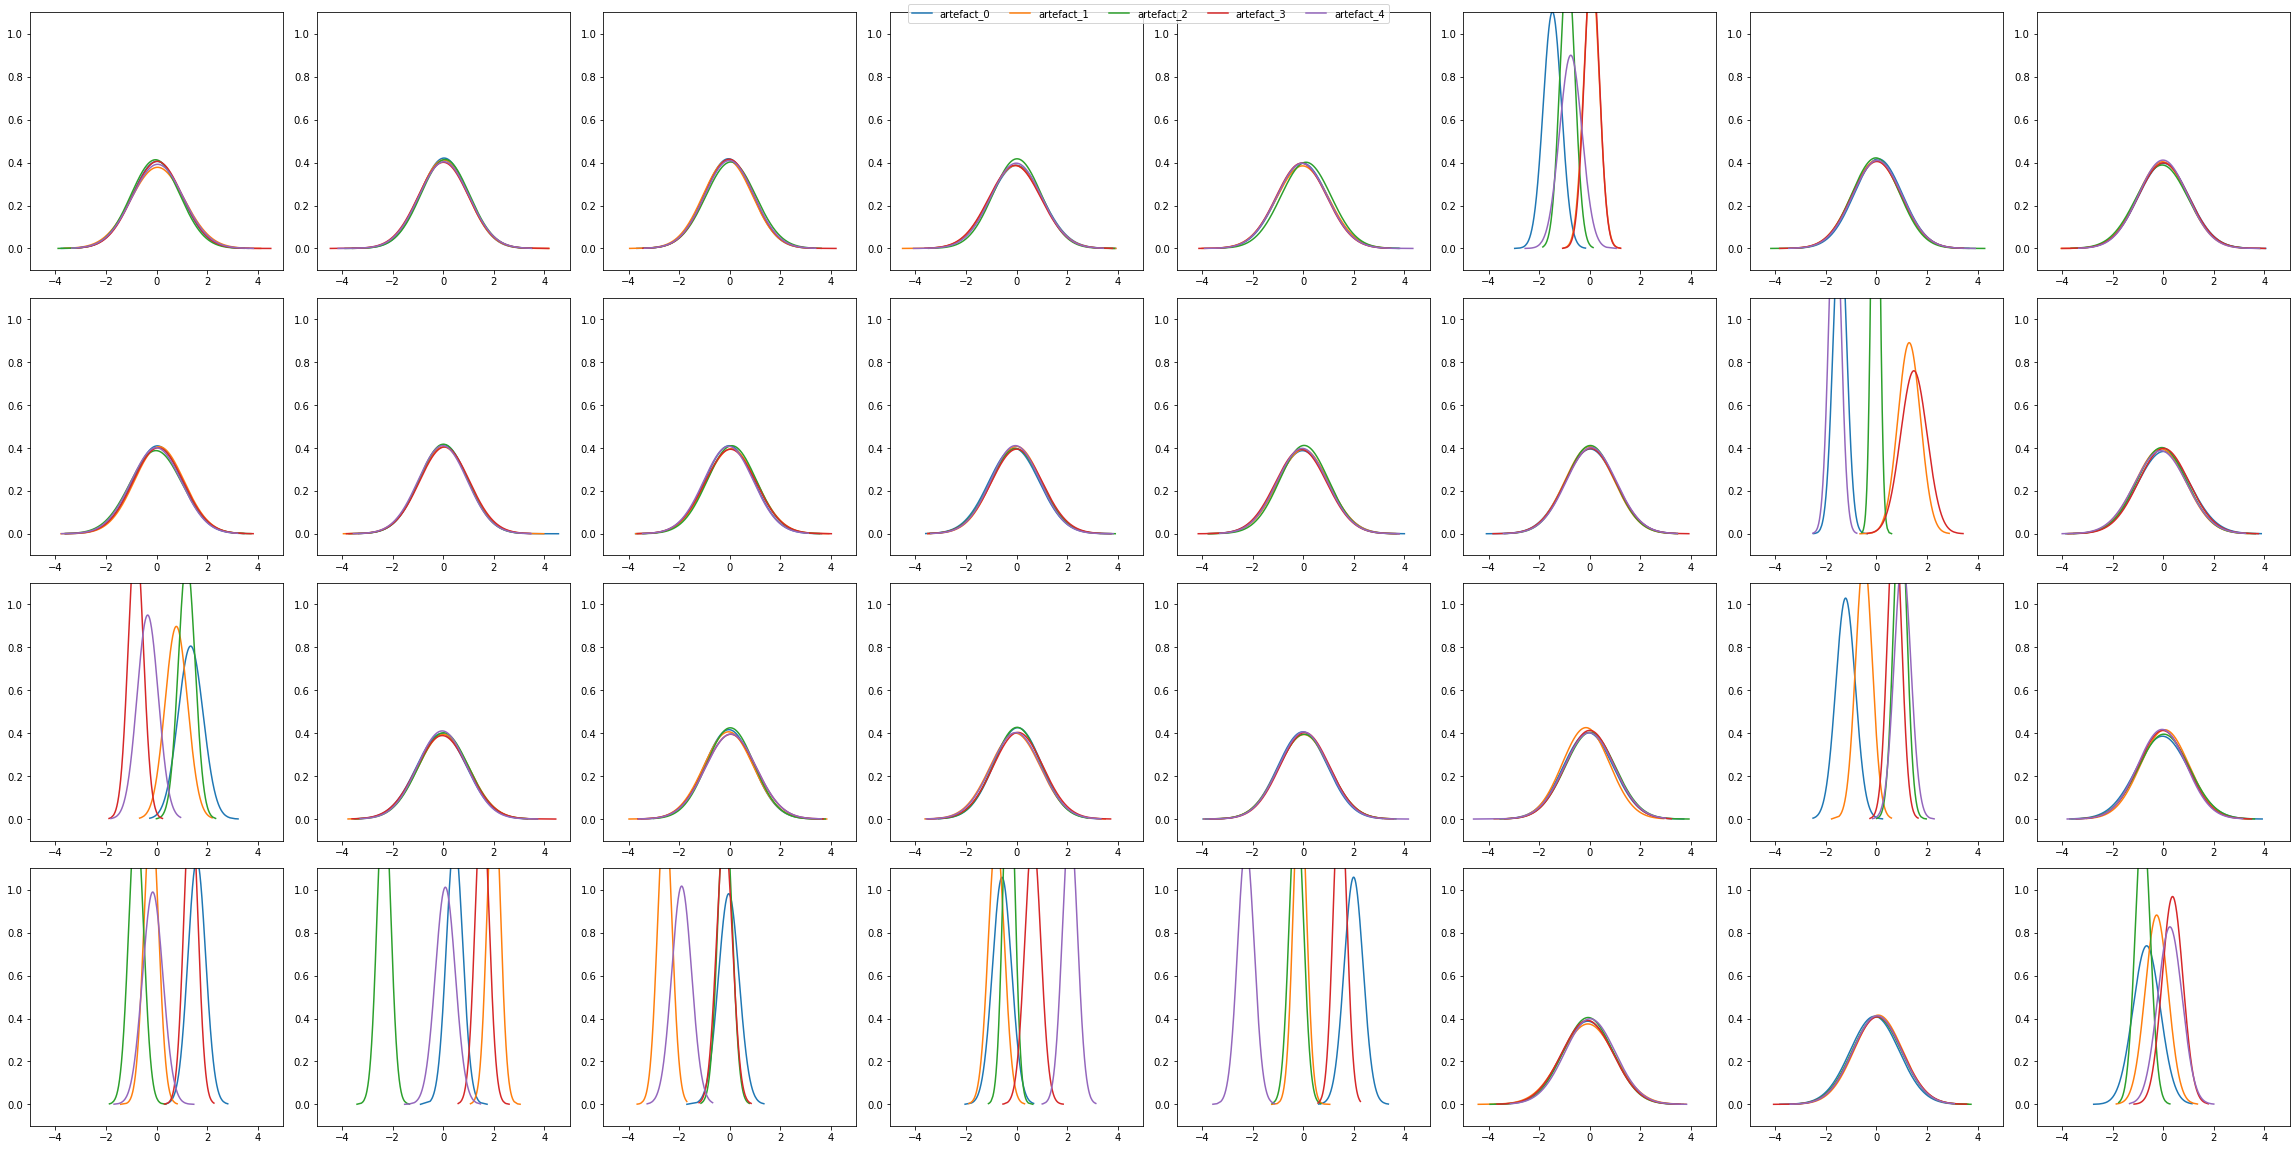

In [157]:
from scipy.stats import norm

selected_x = new_x[:5]
z_mean, z_logvar, z = cs.encode(selected_x)

fig, axs = plt.subplots(4, 8, figsize=(4 * 8, 4 * 4))
labels = [f"artefact_{i}" for i in range(0, len(selected_x))]

for i, ax in enumerate(axs.flatten()):

    for j in range(0, len(selected_x)):
        std = np.exp(0.5 * z_logvar[j][i]) # make the plots a bit saner
        h = sorted(np.random.normal(z_mean[j][i], std, 5000))
        pdf = norm.pdf(h, np.mean(h), np.std(h))
        ax.plot(h, pdf, label=labels[j])   
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-5, 5)

fig.legend(loc="upper center", labels=labels, ncol=len(new_x))
plt.tight_layout()
plt.show()

In [158]:
a = new_y[3]
b = new_y[4]

z_a = z[3]
z_b = z[4]

interpolated_z = interpolate(z_a, z_b, 10)

print(decode(a))
print('-' * 27 + ' FROM ' + '-' * 27)

i_artefacts = cs.decode(interpolated_z).numpy()

    if not np.array_equiv(original, ):
        missclassifieds += 1

for i_a in i_artefacts:
    print(np.array([int(round(note)) for note in ia]))

print('-' * 28 + ' TO ' + '-' * 28)
print(decode(b))

NameError: name 'decode' is not defined

In [144]:
a = new_y[3]
b = new_y[4]

z_a = z[3]
z_b = z[4]

interpolated_z = interpolate(z_a, z_b, 10)

print(decode(a))
print('-' * 27 + ' FROM ' + '-' * 27)

i_artefacts = cs.decode(interpolated_z).numpy()

for i_a in i_artefacts:
    print(decode(i_a))

print('-' * 28 + ' TO ' + '-' * 28)
print(decode(b))

['30', '29', '26', '34', '34', '25', '25', '32', '31', '24']
--------------------------- FROM ---------------------------
['30', '29', '26', '34', '34', '25', '25', '32', '24', '24']
['30', '29', '26', '34', '34', '25', '25', '32', '24', '24']
['30', '29', '26', '34', '34', '25', '25', '32', '24', '24']
['30', '29', '26', '34', '34', '25', '25', '32', '31', '24']
['30', '29', '26', '34', '34', '25', '25', '31', '31', '24']
['33', '29', '26', '31', '24', '32', '32', '31', '31', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
---------------------------- TO ----------------------------
['33', '29', '26', '31', '24', '32', '28', '26', '26', '31']
